# Vanilla GAN for MNIST (PyTorch)

vannila_gan.ipynb で うまく行かなかった(Dが0に収束してしまう)ので、以下の改善を行う。
- ReLU の 代わりにLeakyReLUを使う。
- BatchNormalizationを使う。
- Adam の 学習率を小さくする。
- ノイズは正規分布からサンプリングする。
- ネットワークのニューロン数を変更する。

参考:
- [soumith/ganhacks: starter from "How to Train a GAN?" at NIPS2016](https://github.com/soumith/ganhacks)

In [3]:
% matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t

from torchvision import datasets, models, transforms, utils
import torchvision.utils as vutils

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import os

## mnist datasetの準備

In [4]:
bs = 100

In [5]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=bs
)

## Model

In [6]:
'''Discriminater'''
class netD(nn.Module):
    def __init__(self):
        super(netD, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        x = self.main(x)
        return x

'''Generator'''
class netG(nn.Module):
    def __init__(self):
        super(netG, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1*28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(bs,100)
        x = self.main(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [7]:
criteion = nn.BCELoss()
net_D = netD()
net_G = netG()

if torch.cuda.is_available():
    D = net_D.cuda()
    G = net_G.cuda()
    criteion = criteion.cuda()    

In [9]:
optimizerD = optim.Adam(net_D.parameters(), lr = 0.00005)
optimizerG = optim.Adam(net_G.parameters(), lr = 0.00005)

## Train

In [10]:
input = t.FloatTensor(bs, 1, 28, 28)
noise = t.FloatTensor(normal(0, 1,(bs, 100, 1, 1)))
fixed_noise = t.FloatTensor(bs, 100, 1, 1).normal_(0, 1)
label = t.FloatTensor(bs)

real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

In [11]:
niter = 4000

In [12]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real (data)
        net_D.zero_grad()
        real, _ = data
        input.data.resize_(real.size()).copy_(real)
        label.data.resize_(bs).fill_(real_label)

        output = net_D(input)
        errD_real = criteion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        #train with fake (generated)
        noise.data.resize_(bs, 100, 1, 1)
        noise.data.normal_(0, 1)
        fake = net_G(noise)
        label.data.fill_(fake_label)
        output = net_D(fake.detach())
        errD_fake = criteion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_G.zero_grad()
        label.data.fill_(real_label)
        output = net_D(fake)
        errG = criteion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                 % (epoch, niter, i, len(dataloader),
                   errD.data[0], errG.data[0],  D_x, D_G_z1, D_G_z2))
    if epoch % 10 == 0:
        fake = net_G(fixed_noise)
        vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png'
                              % ('results', epoch),normalize=True)

[0/4000][0/600] Loss_D: 1.3885 Loss_G: 0.7193 D(x): 0.5018 D(G(z)): 0.5029 / 0.4871
[0/4000][100/600] Loss_D: 0.2039 Loss_G: 4.1782 D(x): 0.8943 D(G(z)): 0.0672 / 0.0608
[0/4000][200/600] Loss_D: 0.3222 Loss_G: 3.9727 D(x): 0.8210 D(G(z)): 0.0836 / 0.0762
[0/4000][300/600] Loss_D: 0.2737 Loss_G: 2.9381 D(x): 0.8235 D(G(z)): 0.0632 / 0.0626
[0/4000][400/600] Loss_D: 0.1356 Loss_G: 3.3121 D(x): 0.9232 D(G(z)): 0.0521 / 0.0406
[0/4000][500/600] Loss_D: 0.1118 Loss_G: 3.3953 D(x): 0.9374 D(G(z)): 0.0428 / 0.0367
[1/4000][0/600] Loss_D: 0.0891 Loss_G: 3.9906 D(x): 0.9615 D(G(z)): 0.0463 / 0.0256
[1/4000][100/600] Loss_D: 0.1392 Loss_G: 3.1369 D(x): 0.9465 D(G(z)): 0.0652 / 0.0549
[1/4000][200/600] Loss_D: 0.1490 Loss_G: 3.5705 D(x): 0.9557 D(G(z)): 0.0707 / 0.0501
[1/4000][300/600] Loss_D: 0.1450 Loss_G: 3.3625 D(x): 0.9671 D(G(z)): 0.0888 / 0.0581
[1/4000][400/600] Loss_D: 0.1139 Loss_G: 3.3370 D(x): 0.9723 D(G(z)): 0.0782 / 0.0482
[1/4000][500/600] Loss_D: 0.2371 Loss_G: 2.9955 D(x): 0.92

[16/4000][0/600] Loss_D: 0.3111 Loss_G: 4.6631 D(x): 0.9173 D(G(z)): 0.0490 / 0.0298
[16/4000][100/600] Loss_D: 0.2168 Loss_G: 3.9748 D(x): 0.9185 D(G(z)): 0.0514 / 0.0434
[16/4000][200/600] Loss_D: 0.2139 Loss_G: 3.4214 D(x): 0.9595 D(G(z)): 0.0956 / 0.0674
[16/4000][300/600] Loss_D: 0.2179 Loss_G: 3.9391 D(x): 0.9377 D(G(z)): 0.0506 / 0.0394
[16/4000][400/600] Loss_D: 0.1874 Loss_G: 4.2472 D(x): 0.9392 D(G(z)): 0.0703 / 0.0507
[16/4000][500/600] Loss_D: 0.3276 Loss_G: 3.8257 D(x): 0.8834 D(G(z)): 0.0516 / 0.0435
[17/4000][0/600] Loss_D: 0.3193 Loss_G: 3.6067 D(x): 0.8978 D(G(z)): 0.0738 / 0.0794
[17/4000][100/600] Loss_D: 0.1693 Loss_G: 4.2673 D(x): 0.9341 D(G(z)): 0.0389 / 0.0303
[17/4000][200/600] Loss_D: 0.1585 Loss_G: 3.8715 D(x): 0.9612 D(G(z)): 0.0853 / 0.0533
[17/4000][300/600] Loss_D: 0.1994 Loss_G: 3.8724 D(x): 0.9556 D(G(z)): 0.0816 / 0.0594
[17/4000][400/600] Loss_D: 0.1796 Loss_G: 4.1420 D(x): 0.9452 D(G(z)): 0.0425 / 0.0359
[17/4000][500/600] Loss_D: 0.3352 Loss_G: 3.525

[31/4000][500/600] Loss_D: 0.4482 Loss_G: 3.0086 D(x): 0.8355 D(G(z)): 0.1195 / 0.1058
[32/4000][0/600] Loss_D: 0.4014 Loss_G: 2.7634 D(x): 0.8808 D(G(z)): 0.1210 / 0.1173
[32/4000][100/600] Loss_D: 0.4384 Loss_G: 2.5910 D(x): 0.8899 D(G(z)): 0.1768 / 0.1514
[32/4000][200/600] Loss_D: 0.4307 Loss_G: 2.6906 D(x): 0.9041 D(G(z)): 0.1673 / 0.1269
[32/4000][300/600] Loss_D: 0.5853 Loss_G: 2.8867 D(x): 0.8435 D(G(z)): 0.1299 / 0.1147
[32/4000][400/600] Loss_D: 0.4945 Loss_G: 3.2311 D(x): 0.8245 D(G(z)): 0.0995 / 0.0867
[32/4000][500/600] Loss_D: 0.4423 Loss_G: 2.5647 D(x): 0.8469 D(G(z)): 0.1418 / 0.1407
[33/4000][0/600] Loss_D: 0.3679 Loss_G: 2.7405 D(x): 0.8932 D(G(z)): 0.1144 / 0.1143
[33/4000][100/600] Loss_D: 0.3952 Loss_G: 3.1117 D(x): 0.8619 D(G(z)): 0.1011 / 0.0919
[33/4000][200/600] Loss_D: 0.3674 Loss_G: 3.2870 D(x): 0.9140 D(G(z)): 0.1327 / 0.0875
[33/4000][300/600] Loss_D: 0.4402 Loss_G: 2.7176 D(x): 0.8792 D(G(z)): 0.1466 / 0.1361
[33/4000][400/600] Loss_D: 0.4532 Loss_G: 3.222

[47/4000][400/600] Loss_D: 0.4955 Loss_G: 3.1368 D(x): 0.8299 D(G(z)): 0.1138 / 0.0966
[47/4000][500/600] Loss_D: 0.7079 Loss_G: 2.6287 D(x): 0.7893 D(G(z)): 0.1397 / 0.1323
[48/4000][0/600] Loss_D: 0.6683 Loss_G: 2.2204 D(x): 0.8390 D(G(z)): 0.2382 / 0.2117
[48/4000][100/600] Loss_D: 0.4372 Loss_G: 2.7433 D(x): 0.8690 D(G(z)): 0.1221 / 0.1217
[48/4000][200/600] Loss_D: 0.2916 Loss_G: 3.3190 D(x): 0.9116 D(G(z)): 0.1089 / 0.0736
[48/4000][300/600] Loss_D: 0.4447 Loss_G: 2.5820 D(x): 0.9055 D(G(z)): 0.1916 / 0.1557
[48/4000][400/600] Loss_D: 0.5110 Loss_G: 2.7817 D(x): 0.8397 D(G(z)): 0.1380 / 0.1137
[48/4000][500/600] Loss_D: 0.4582 Loss_G: 2.8895 D(x): 0.8447 D(G(z)): 0.1045 / 0.1043
[49/4000][0/600] Loss_D: 0.4709 Loss_G: 2.8786 D(x): 0.8617 D(G(z)): 0.1580 / 0.1431
[49/4000][100/600] Loss_D: 0.3867 Loss_G: 2.6986 D(x): 0.8875 D(G(z)): 0.1357 / 0.1302
[49/4000][200/600] Loss_D: 0.3329 Loss_G: 2.8842 D(x): 0.9104 D(G(z)): 0.1071 / 0.0928
[49/4000][300/600] Loss_D: 0.4008 Loss_G: 2.788

[63/4000][300/600] Loss_D: 0.5626 Loss_G: 2.9668 D(x): 0.8002 D(G(z)): 0.0988 / 0.0850
[63/4000][400/600] Loss_D: 0.6127 Loss_G: 2.0733 D(x): 0.8304 D(G(z)): 0.2181 / 0.1982
[63/4000][500/600] Loss_D: 0.5197 Loss_G: 2.5897 D(x): 0.8212 D(G(z)): 0.1296 / 0.1184
[64/4000][0/600] Loss_D: 0.5690 Loss_G: 2.4382 D(x): 0.8150 D(G(z)): 0.1742 / 0.1559
[64/4000][100/600] Loss_D: 0.5931 Loss_G: 2.2840 D(x): 0.8162 D(G(z)): 0.1916 / 0.1830
[64/4000][200/600] Loss_D: 0.3738 Loss_G: 2.4284 D(x): 0.9074 D(G(z)): 0.1810 / 0.1478
[64/4000][300/600] Loss_D: 0.6382 Loss_G: 1.9895 D(x): 0.8565 D(G(z)): 0.2532 / 0.2078
[64/4000][400/600] Loss_D: 0.5893 Loss_G: 2.3195 D(x): 0.8205 D(G(z)): 0.1878 / 0.1650
[64/4000][500/600] Loss_D: 0.6946 Loss_G: 2.3113 D(x): 0.7838 D(G(z)): 0.1544 / 0.1530
[65/4000][0/600] Loss_D: 0.4942 Loss_G: 2.2945 D(x): 0.8534 D(G(z)): 0.1856 / 0.1752
[65/4000][100/600] Loss_D: 0.5776 Loss_G: 2.3553 D(x): 0.8104 D(G(z)): 0.1681 / 0.1568
[65/4000][200/600] Loss_D: 0.3353 Loss_G: 2.801

KeyboardInterrupt: 

In [13]:
fake = net_G(fixed_noise)
vutils.save_image(fake.data[:64], '%s/fake_samples2.png' % 'results' ,normalize=True)

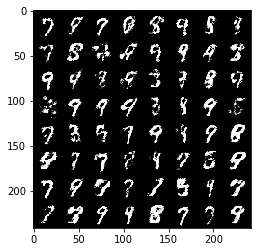

In [14]:
from PIL import Image
im = Image.open("results/fake_samples2.png", "r")
plt.imshow(np.array(im))